# Useless file

Runs into a NameError long down the line.

```python
NameError                                 Traceback (most recent call last)
Cell In[36], line 4
      1 future_dates = pd.date_range("2025-01-01", "2025-05-31", freq="D")
      3 # Use only your 12 active rm_ids (seasonal + emerging)
----> 4 active_rm_ids = seasonal_rms + emerging_rms
      6 # Create full index of (rm_id, date) combinations ---
      7 submission_frame = (
      8     pd.MultiIndex
      9     .from_product([active_rm_ids, future_dates], names=['rm_id', 'date'])
     10     .to_frame()
     11     .reset_index(drop=True)
     12 )

NameError: name 'seasonal_rms' is not defined
```

# XGBoost submission v1

Steps:

1. Create Tabular Data with all active raw materials.
2. Add features (lags, etc.)
3. Train model
4. Create a submission frame
5. Forecast

# Do things better!

- Train on actual cummulative net weights in the right time period (we do not care about stationarity)
- Create features out of purchases (Orders of last year to arrive in the time period forecasted)

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import autogluon
from tqdm import tqdm
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import os
from collections import deque
import ipynbname

# Set plot style for visual clarity
plt.style.use('seaborn-v0_8')

In [ ]:
project_root = str(ipynbname.path().parent.parent.parent)
if os.getcwd() != project_root:
    os.chdir(project_root)

In [39]:
# Load the receival data
receivals = pd.read_csv('./data/kernel/receivals.csv')

# Load purchases
purchases = pd.read_csv('./data/kernel/purchase_orders.csv')

#----------------------------------------------------------

# Load materials
materials = pd.read_csv('./data/extended/materials.csv').dropna()

# load transportation
transportation = pd.read_csv('./data/extended/transportation.csv')

# Load prediction mapping
prediction_mapping = pd.read_csv('./data/prediction_mapping.csv')

In [121]:
prediction_mapping

,ID,rm_id,forecast_start_date,forecast_end_date
0,1,365,2025-01-01,2025-01-02
1,2,365,2025-01-01,2025-01-03
2,3,365,2025-01-01,2025-01-04
3,4,365,2025-01-01,2025-01-05
4,5,365,2025-01-01,2025-01-06
...,...,...,...,...
30445,30446,4501,2025-01-01,2025-05-27
30446,30447,4501,2025-01-01,2025-05-28
30447,30448,4501,2025-01-01,2025-05-29
30448,30449,4501,2025-01-01,2025-05-30


### What materials are active in the forecasting period 2025?

In [259]:
materials

,rm_id,product_id,product_version,raw_material_alloy,raw_material_format_type,stock_location,deletion_date
1,342.0,91900170.0,1.0,SB06 Traders,24.0,DELETED_28.02:2011_SB06 anodiz,2011-02-28
2,343.0,91900143.0,2.0,SB02 606035,24.0,SB 02,NaT
3,345.0,91900143.0,2.0,SA10 606035,3.0,DELETED_28.02:2011_ST01,2011-02-28
4,346.0,91900146.0,2.0,SA15 600540,3.0,DELETED_28.02:2011_SA 300370,2011-02-28
5,347.0,91900143.0,2.0,SA13 606020,3.0,DELETED_28.02:2011_SA13 6035,2011-02-28
...,...,...,...,...,...,...,...
1213,4462.0,91901113.0,3.0,CPS 6082 (anodizado),35.0,SB 16,NaT
1214,4463.0,91900304.0,3.0,CPS 6082 (lacado),35.0,SA 00,NaT
1215,4481.0,91901215.0,2.0,Melé 95% PC - Acín,47.0,SB 15,NaT
1216,4481.0,91901215.0,9.0,Melé 95% PC - Acín,47.0,SB 18 A,NaT


In [74]:
# Load materials
materials = pd.read_csv('./data/extended/materials.csv').dropna()


def parse_deletion_date(s):
    """
    Extracts a deletion date from strings like 'DELETED_12.05:2025_SB 16 B'.
    Returns NaT if no valid date is found.
    """
    if isinstance(s, str) and s.startswith("DELETED_"):
        try:
            # "DELETED_12.05:2025_SB..." → "12.05:2025" → "12.05.2025"
            date_part = s.split("_")[1].replace(":", ".")
            return pd.to_datetime(date_part, format="%d.%m.%Y", errors="coerce")
        except Exception:
            return pd.NaT
    return pd.NaT

materials["deletion_date"] = materials["stock_location"].apply(parse_deletion_date)

# Sort by product_id + version, newest first
materials_sorted = (
    materials
    .sort_values(["product_id", "product_version"], ascending=[True, False])
)

materials_latest = (
    materials_sorted
    .drop_duplicates(subset="product_id", keep="first")
    .reset_index(drop=True)
)

start = pd.Timestamp("2025-01-01")
end = pd.Timestamp("2025-05-31")

# Filter for materials active at any time during that window
materials_active = materials_latest[
    (
        materials_latest["deletion_date"].isna()  # still active
        | (materials_latest["deletion_date"] >= start)  # deleted after our start date
    )
]

# flag which are still active after the horizon
materials_active["is_active_after_horizon"] = (
    materials_active["deletion_date"].isna()
    | (materials_active["deletion_date"] > end)
)

# Extract list of rm_ids
active_rms = materials_active["rm_id"].dropna().unique().tolist()

print(f"Active raw materials in 2025-H1: {len(active_rms)}")
# display(materials_active[["rm_id", "product_id", "product_version", "deletion_date", "is_active_after_horizon"]])

Active raw materials in 2025-H1: 52


C:\Users\maxiw\AppData\Local\Temp\ipykernel_17440\2636622372.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  materials_active["is_active_after_horizon"] = (


In [260]:
materials_active

,rm_id,product_id,product_version,raw_material_alloy,raw_material_format_type,stock_location,deletion_date,is_active_after_horizon
0,383.0,1002.0,2.0,AAMn 80%,19.0,AAMN,NaT,True
1,2402.0,1025.0,9.0,TI-Bors rod,31.0,AA07,NaT,True
2,3601.0,1026.0,16.0,Ti - Bors,31.0,AA06,NaT,True
3,2125.0,1034.0,28.0,Mg 100%,12.0,AA02,NaT,True
4,2124.0,1160.0,26.0,Mn 80%,19.0,AA03,NaT,True
5,2123.0,1177.0,27.0,Si 100%,16.0,AA01,NaT,True
6,2161.0,1307.0,26.0,Cu 80%,19.0,AA04,NaT,True
8,381.0,1608.0,2.0,AAMg 100%,12.0,AA02,NaT,True
9,2121.0,1687.0,15.0,Cr 75%,19.0,AA05,NaT,True
10,2127.0,1807.0,6.0,Ti-Bors,7.0,AA00,NaT,True


In [73]:
# SOME follow-up ANALYSIS
#------------------------

# There should only appear product_id s contained in this table in the purchases table where the delivery_date is in the forecasting period.
# Check this:

purchases["delivery_date"] = (
    pd.to_datetime(purchases["delivery_date"], utc=True, errors="coerce")
    .dt.tz_convert(None)
)

# --- 3️⃣ Define forecast window (naive datetimes) ---
start = pd.Timestamp("2025-01-01")
end   = pd.Timestamp("2025-05-31")

# --- 4️⃣ Filter to forecasting period ---
purchases_forecast = purchases[
    (purchases["delivery_date"] >= start) &
    (purchases["delivery_date"] <= end)
]

# --- Product IDs that appear in purchases but not in active materials ---
unexpected_products = set(purchases_forecast["product_id"]) - set(materials_active["product_id"])

# --- Report results ---
if len(unexpected_products) == 0:
    print("✅ All product_ids in purchases during the forecast period are present in materials_active.")
else:
    print(f"⚠️ {len(unexpected_products)} unexpected product_id(s) found in 2025H1 purchases:")
    print(list(unexpected_products))

ordered_product_ids = set(purchases["product_id"].dropna())
never_ordered_products = set(materials_active["product_id"]) - ordered_product_ids

if len(never_ordered_products) == 0:
    print("\n✅ All active materials have at least one purchase order in the dataset.")
else:
    print(f"\nℹ️ {len(never_ordered_products)} product_id(s) in materials_active were never ordered:")
    print(list(never_ordered_products)[:20])

✅ All product_ids in purchases during the forecast period are present in materials_active.

ℹ️ 1 product_id(s) in materials_active were never ordered:
[1002.0]


In [81]:
# --- 1️⃣ Define your time window ---
start = pd.Timestamp("2025-01-01")
end   = pd.Timestamp("2025-05-31")

# --- 2️⃣ Convert datetime columns safely ---
purchases["created_date_time"] = (
    pd.to_datetime(purchases["created_date_time"], utc=True, errors="coerce").dt.tz_convert(None)
)
purchases["delivery_date"] = (
    pd.to_datetime(purchases["delivery_date"], utc=True, errors="coerce").dt.tz_convert(None)
)

# --- 3️⃣ Filter: created before 2024, delivered Jan–May 2024 ---
purchases_pre2024_created_2024delivered = purchases[
    (purchases["created_date_time"] < start) &
    (purchases["delivery_date"] >= start) &
    (purchases["delivery_date"] <= end)
].reset_index(drop=True)

# --- 4️⃣ Preview ---
print(f"Filtered rows: {len(purchases_pre2024_created_2024delivered)}")
display(purchases_pre2024_created_2024delivered)

Filtered rows: 147


,purchase_order_id,purchase_order_item_no,quantity,delivery_date,product_id,product_version,created_date_time,modified_date_time,unit_id,unit,status_id,status
0,323595,20,25000.0,2025-04-29 22:00:00,91901215,4,2023-10-02 10:33:18,2025-04-30 08:31:58.0000000 +00:00,40.0,KG,2,Closed
1,323595,30,25000.0,2025-04-29 22:00:00,91901215,4,2023-10-02 10:33:18,2025-04-30 08:31:58.0000000 +00:00,40.0,KG,2,Closed
2,327390,10,25000.0,2025-03-30 22:00:00,91901215,4,2024-05-28 13:20:19,2025-06-09 12:51:18.0000000 +00:00,40.0,KG,2,Closed
3,330446,10,100000.0,2025-03-30 22:00:00,91900143,9,2024-11-21 10:40:50,2024-12-19 11:22:55.0000000 +00:00,40.0,KG,3,Deleted
4,330484,10,200000.0,2025-01-31 23:00:00,91900274,7,2024-11-26 09:49:52,2025-03-07 08:52:12.0000000 +00:00,40.0,KG,2,Closed
...,...,...,...,...,...,...,...,...,...,...,...,...
142,331152,10,100000.0,2025-01-30 23:00:00,91901460,1,2024-12-20 11:41:29,2025-02-19 12:57:21.0000000 +00:00,40.0,KG,2,Closed
143,331202,10,50000.0,2025-01-30 23:00:00,91901460,1,2024-12-27 09:53:18,2025-02-19 12:57:22.0000000 +00:00,40.0,KG,2,Closed
144,331202,20,50000.0,2025-01-30 23:00:00,91901460,1,2024-12-27 09:53:17,2025-02-19 12:57:22.0000000 +00:00,40.0,KG,2,Closed
145,331202,30,50000.0,2025-01-30 23:00:00,91901460,1,2024-12-27 09:53:18,2025-02-19 12:57:22.0000000 +00:00,40.0,KG,2,Closed


## Preprocess materials

In [97]:
product_to_rm = (
    materials[["product_id", "rm_id"]]
    .dropna()
    .set_index("product_id")["rm_id"]
    .to_dict()
)

print(f"✅ Created mapping for {len(product_to_rm)} product_ids.")
print("Example mappings:", list(product_to_rm.items())[:10])

✅ Created mapping for 54 product_ids.
Example mappings: [(91900170.0, 2201.0), (91900143.0, 3865.0), (91900146.0, 3941.0), (91900182.0, 3821.0), (91900152.0, 4443.0), (91900160.0, 3421.0), (91900296.0, 2159.0), (91900302.0, 2142.0), (1177.0, 2123.0), (1608.0, 1875.0)]


In [99]:
len(set(materials['rm_id']))

203

In [261]:
materials

,rm_id,product_id,product_version,raw_material_alloy,raw_material_format_type,stock_location,deletion_date
1,342.0,91900170.0,1.0,SB06 Traders,24.0,DELETED_28.02:2011_SB06 anodiz,2011-02-28
2,343.0,91900143.0,2.0,SB02 606035,24.0,SB 02,NaT
3,345.0,91900143.0,2.0,SA10 606035,3.0,DELETED_28.02:2011_ST01,2011-02-28
4,346.0,91900146.0,2.0,SA15 600540,3.0,DELETED_28.02:2011_SA 300370,2011-02-28
5,347.0,91900143.0,2.0,SA13 606020,3.0,DELETED_28.02:2011_SA13 6035,2011-02-28
...,...,...,...,...,...,...,...
1213,4462.0,91901113.0,3.0,CPS 6082 (anodizado),35.0,SB 16,NaT
1214,4463.0,91900304.0,3.0,CPS 6082 (lacado),35.0,SA 00,NaT
1215,4481.0,91901215.0,2.0,Melé 95% PC - Acín,47.0,SB 15,NaT
1216,4481.0,91901215.0,9.0,Melé 95% PC - Acín,47.0,SB 18 A,NaT


## Preprocess receivals

In [100]:
# Convert 'date_arrival' to timezone-naive datetime
receivals['date_arrival'] = pd.to_datetime(receivals['date_arrival'], utc=True).dt.tz_localize(None)

# Drop all rows where rm_id is missing

receivals = receivals.dropna(subset=['rm_id']).copy()

receivals = receivals.dropna(subset=['net_weight']).copy()
receivals = receivals.drop_duplicates().copy()

# Keep only active raw materials
receivals = receivals[receivals["rm_id"].isin(active_rms)].copy()

receivals

,rm_id,product_id,purchase_order_id,purchase_order_item_no,receival_item_no,batch_id,date_arrival,receival_status,net_weight,supplier_id
192,381.0,1608.0,210325.0,10.0,1,NaN,2004-06-30 07:21:00,Completed,10610.0,53728
490,383.0,1002.0,210611.0,10.0,1,NaN,2004-07-23 10:32:00,Completed,1080.0,54996
1040,381.0,1608.0,211320.0,10.0,1,NaN,2004-09-29 14:30:00,Completed,10000.0,53728
1256,383.0,1002.0,211726.0,10.0,1,NaN,2004-10-18 10:03:00,Completed,1080.0,54996
1368,383.0,1002.0,211680.0,10.0,1,NaN,2004-10-26 09:42:00,Completed,910.0,57958
...,...,...,...,...,...,...,...,...,...,...
122579,2741.0,91900274.0,327858.0,60.0,1,1178409.0,2024-12-19 08:53:00,Completed,23120.0,76871
122581,2130.0,91900143.0,330596.0,10.0,1,1178420.0,2024-12-19 10:14:00,Completed,24274.0,50363
122582,2134.0,91900146.0,328766.0,20.0,1,1178421.0,2024-12-19 10:23:00,Completed,429.0,50420
122583,2130.0,91900143.0,328766.0,10.0,2,1178433.0,2024-12-19 10:23:00,Completed,7332.0,50420


## Preprocess purchases

In [96]:
for col in ["created_date_time", "modified_date_time", "delivery_date"]:
    purchases[col] = (
        pd.to_datetime(purchases[col], utc=True, errors="coerce")
        .dt.tz_convert(None)
    )

purchases["quantity"] = pd.to_numeric(purchases["quantity"], errors="coerce")
purchases["product_id"] = pd.to_numeric(purchases["product_id"], errors="coerce")
purchases["product_version"] = pd.to_numeric(purchases["product_version"], errors="coerce")

# Remove rows without a product_id or delivery date
purchases = purchases.dropna(subset=["product_id", "delivery_date"])

purchases = purchases.drop_duplicates(
    subset=["purchase_order_id", "purchase_order_item_no"], keep="last"
)

In [101]:
# Map rm_id into purchases based on product_id
purchases["rm_id"] = purchases["product_id"].map(product_to_rm)

# Report coverage
missing_rm = purchases["rm_id"].isna().sum()
total_rows = len(purchases)

print(f"✅ Added 'rm_id' column to purchases.")
print(f"   → {total_rows - missing_rm} rows mapped successfully")
print(f"   → {missing_rm} rows have no rm_id (no active mapping found)")

# Filter out unmapped rows
purchases_filtered = purchases.dropna(subset=["rm_id"]).copy()

print(f"After filtering: {len(purchases_filtered)} purchase rows remain (active materials only).")

✅ Added 'rm_id' column to purchases.
   → 32019 rows mapped successfully
   → 1152 rows have no rm_id (no active mapping found)
After filtering: 32019 purchase rows remain (active materials only).


In [103]:
purchases_filtered

,purchase_order_id,purchase_order_item_no,quantity,delivery_date,product_id,product_version,created_date_time,modified_date_time,unit_id,unit,status_id,status,rm_id
0,1,1,-14.0,2003-05-11 22:00:00,91900143,1,2003-05-12 10:00:48,2004-06-15 06:16:18,NaN,NaN,2,Closed,3865.0
1,22,1,23880.0,2003-05-26 22:00:00,91900160,1,2003-05-27 12:42:07,2012-06-29 09:41:13,NaN,NaN,2,Closed,3421.0
2,41,1,0.0,2004-03-07 23:00:00,91900143,1,2004-03-08 13:44:31,2012-07-04 13:51:02,NaN,NaN,2,Closed,3865.0
3,61,1,0.0,2004-03-09 23:00:00,91900143,1,2004-03-10 11:39:06,2012-07-04 13:50:59,NaN,NaN,2,Closed,3865.0
4,141,10,25000.0,2004-10-27 22:00:00,91900143,1,2004-10-22 12:21:54,2012-07-04 13:50:55,NaN,NaN,2,Closed,3865.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33166,331152,10,100000.0,2025-01-30 23:00:00,91901460,1,2024-12-20 11:41:29,2025-02-19 12:57:21,40.0,KG,2,Closed,4263.0
33167,331202,10,50000.0,2025-01-30 23:00:00,91901460,1,2024-12-27 09:53:18,2025-02-19 12:57:22,40.0,KG,2,Closed,4263.0
33168,331202,20,50000.0,2025-01-30 23:00:00,91901460,1,2024-12-27 09:53:17,2025-02-19 12:57:22,40.0,KG,2,Closed,4263.0
33169,331202,30,50000.0,2025-01-30 23:00:00,91901460,1,2024-12-27 09:53:18,2025-02-19 12:57:22,40.0,KG,2,Closed,4263.0


### Create Data with all active raw materials.

In [104]:
# Aggregate to daily totals per rm_id
receivals_daily = (
    receivals.groupby(['rm_id', receivals['date_arrival'].dt.floor('D')])['net_weight']
    .sum()
    .reset_index()
    .rename(columns={'date_arrival': 'date'})
)

# Sort values for shifting
receivals_daily = receivals_daily.sort_values(['rm_id', 'date'])

receivals_daily

,rm_id,date,net_weight
0,381.0,2004-06-30,10610.0
1,381.0,2004-09-29,10000.0
2,381.0,2004-10-27,10000.0
3,381.0,2005-01-07,10000.0
4,381.0,2005-01-17,1016.0
...,...,...,...
18828,4302.0,2024-11-21,22760.0
18829,4302.0,2024-11-26,22700.0
18830,4401.0,2024-07-30,16640.0
18831,4401.0,2024-07-31,20320.0


In [169]:
# 1. Get full date range
all_dates = pd.date_range(
    start=receivals_daily['date'].min(),
    end=pd.Timestamp("2024-12-31"),
    freq='D'
)
# print(all_dates)

# 2. Get all rm_ids
all_rm_ids = receivals_daily['rm_id'].unique()
print(f"There are {len(all_rm_ids)} different rm_ids")

# 3. Create full Cartesian product of rm_id × date
full_index = pd.MultiIndex.from_product(
    [all_rm_ids, all_dates],
    names=['rm_id', 'date']
)

# 4. Reindex dataframe onto full grid
receivals_full = (
    receivals_daily.set_index(['rm_id', 'date'])
    .reindex(full_index, fill_value=0)  # fill missing with 0
    .reset_index()
)

receivals_full

There are 52 different rm_ids


,rm_id,date,net_weight
0,381.0,2004-06-30,10610.0
1,381.0,2004-07-01,0.0
2,381.0,2004-07-02,0.0
3,381.0,2004-07-03,0.0
4,381.0,2004-07-04,0.0
...,...,...,...
389475,4401.0,2024-12-27,0.0
389476,4401.0,2024-12-28,0.0
389477,4401.0,2024-12-29,0.0
389478,4401.0,2024-12-30,0.0


In [170]:
# Ensure correct sorting
receivals_full = receivals_full.sort_values(["rm_id", "date"]).reset_index(drop=True)

# Add year column
receivals_full["year"] = receivals_full["date"].dt.year

# Compute cumulative weights per rm_id × year
receivals_full["cum_weight"] = (
    receivals_full.groupby(["rm_id", "year"])["net_weight"].cumsum()
)

# Build the rolling forecasting dataframe
# Each row = cumulative total from Jan 1 of that year to that day's end
receivals_ts = (
    receivals_full.assign(
        forecast_start_date=lambda x: pd.to_datetime(x["year"].astype(str) + "-01-01"),
        forecast_end_date=lambda x: x["date"]
    )
    [["date", "forecast_start_date", "forecast_end_date", "rm_id", "year", "cum_weight"]]
    .rename(columns={"cum_weight": "weight_kg"})
    .sort_values(["rm_id", "forecast_end_date"])
    .reset_index(drop=True)
)

num_years = receivals_ts["year"].nunique()
print(f"✅ Created forecasting dataframe with {len(receivals_ts):,} rows across {num_years} years.")
display(receivals_ts)

✅ Created forecasting dataframe with 389,480 rows across 21 years.


,date,forecast_start_date,forecast_end_date,rm_id,year,weight_kg
0,2004-06-30,2004-01-01,2004-06-30,381.0,2004,10610.0
1,2004-07-01,2004-01-01,2004-07-01,381.0,2004,10610.0
2,2004-07-02,2004-01-01,2004-07-02,381.0,2004,10610.0
3,2004-07-03,2004-01-01,2004-07-03,381.0,2004,10610.0
4,2004-07-04,2004-01-01,2004-07-04,381.0,2004,10610.0
...,...,...,...,...,...,...
389475,2024-12-27,2024-01-01,2024-12-27,4401.0,2024,54240.0
389476,2024-12-28,2024-01-01,2024-12-28,4401.0,2024,54240.0
389477,2024-12-29,2024-01-01,2024-12-29,4401.0,2024,54240.0
389478,2024-12-30,2024-01-01,2024-12-30,4401.0,2024,54240.0


In [171]:
# Delete 2004 since we do not have full time series

receivals_ts = receivals_ts[receivals_ts["year"] != 2004].reset_index(drop=True)

# Drop rows where forecast_start_date == forecast_end_date
receivals_ts = receivals_ts[
    receivals_ts["forecast_start_date"] != receivals_ts["forecast_end_date"]
].reset_index(drop=True)

## Add features

In [172]:
# temporal features
receivals_ts['month'] = receivals_ts['date'].dt.month
receivals_ts['day'] = receivals_ts['date'].dt.day
receivals_ts['dayofweek'] = receivals_ts['date'].dt.dayofweek
receivals_ts['is_weekend'] = receivals_ts['dayofweek'].isin([5,6]).astype(int)

receivals_ts["day_of_year"] = receivals_ts["date"].dt.dayofyear
receivals_ts["sin_day"] = np.sin(2 * np.pi * receivals_ts["day_of_year"] / 365)
receivals_ts["cos_day"] = np.cos(2 * np.pi * receivals_ts["day_of_year"] / 365)

# add number of days in the forecasting period
receivals_ts["days_in_period"] = (
    (receivals_ts["forecast_end_date"] - receivals_ts["forecast_start_date"]).dt.days + 1
)

In [173]:
receivals_ts

,date,forecast_start_date,forecast_end_date,rm_id,year,weight_kg,month,day,dayofweek,is_weekend,day_of_year,sin_day,cos_day,days_in_period
0,2005-01-02,2005-01-01,2005-01-02,381.0,2005,0.0,1,2,6,1,2,3.442161e-02,0.999407,2
1,2005-01-03,2005-01-01,2005-01-03,381.0,2005,0.0,1,3,0,0,3,5.161967e-02,0.998667,3
2,2005-01-04,2005-01-01,2005-01-04,381.0,2005,0.0,1,4,1,0,4,6.880243e-02,0.997630,4
3,2005-01-05,2005-01-01,2005-01-05,381.0,2005,0.0,1,5,2,0,5,8.596480e-02,0.996298,5
4,2005-01-06,2005-01-01,2005-01-06,381.0,2005,0.0,1,6,3,0,6,1.031017e-01,0.994671,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378815,2024-12-27,2024-01-01,2024-12-27,4401.0,2024,54240.0,12,27,4,0,362,-5.161967e-02,0.998667,362
378816,2024-12-28,2024-01-01,2024-12-28,4401.0,2024,54240.0,12,28,5,1,363,-3.442161e-02,0.999407,363
378817,2024-12-29,2024-01-01,2024-12-29,4401.0,2024,54240.0,12,29,6,1,364,-1.721336e-02,0.999852,364
378818,2024-12-30,2024-01-01,2024-12-30,4401.0,2024,54240.0,12,30,0,0,365,6.432491e-16,1.000000,365


In [149]:
# Add features from purchases

In [174]:
def compute_expected_deliveries(purchases_filtered, receivals_ts, active_rms):
    """
    For each (rm_id, forecast_start_date, forecast_end_date) period,
    calculate cumulative quantity of all purchase orders
    with delivery_date in that window and created before the start date.
    Returns a dataframe ready to join with receivals_ts.
    """
    # --- Prepare list to store results ---
    results = []

    # --- Iterate over unique forecasting periods ---
    periods = (
        receivals_ts[["forecast_start_date", "forecast_end_date"]]
        .drop_duplicates()
        .sort_values("forecast_end_date")
        .to_records(index=False)
    )

    # ✅ Add artificial forecast periods for 2025
    # Define all daily end dates in the forecasting period of 2025
    dates_2025 = pd.date_range("2025-01-01", "2025-05-31", freq="D")
    
    # Build matching start dates (always 2025-01-01)
    forecast_start_2025 = [pd.Timestamp("2025-01-01")] * len(dates_2025)
    
    # Convert to structured array with same dtype as periods
    periods_2025 = list(zip(forecast_start_2025, dates_2025))
    
    # Append them to existing periods
    periods = list(periods) + periods_2025
    

    for start, end in tqdm(periods, desc="Computing expected deliveries"):
        # select relevant purchase orders (created before start, delivered within window)
        mask = (
            (purchases_filtered["created_date_time"] < start)
            & (purchases_filtered["delivery_date"] >= start)
            & (purchases_filtered["delivery_date"] <= end)
        )
        temp = (
            purchases_filtered[mask]
            .groupby("rm_id", as_index=False)["quantity"]
            .sum()
            .rename(columns={"quantity": "expected_delivery_qty"})
        )
        
        # ✅ Reindex to all active rm_ids — fill missing with 0
        # this way there are not only periods in it which actually have purchase orders.
        temp = (
            temp.set_index("rm_id")
            .reindex(active_rms, fill_value=0)
            .reset_index()
        )

        temp["forecast_start_date"] = start
        temp["forecast_end_date"] = end

        results.append(temp)

    # --- Combine all results ---
    expected_deliveries = pd.concat(results, ignore_index=True)

    print(f"✅ Created expected deliveries table with {len(expected_deliveries):,} rows.")
    return expected_deliveries

In [175]:
expected_deliveries = compute_expected_deliveries(purchases_filtered, receivals_ts, active_rms)

Computing expected deliveries: 100%|██████████| 7436/7436 [00:56<00:00, 130.79it/s]


✅ Created expected deliveries table with 386,672 rows.


In [176]:
expected_deliveries.sort_values(["rm_id", "forecast_end_date"])

,rm_id,expected_delivery_qty,forecast_start_date,forecast_end_date
7,381.0,0.0,2005-01-01,2005-01-02
59,381.0,0.0,2005-01-01,2005-01-03
111,381.0,0.0,2005-01-01,2005-01-04
163,381.0,0.0,2005-01-01,2005-01-05
215,381.0,0.0,2005-01-01,2005-01-06
...,...,...,...,...
386453,4401.0,0.0,2025-01-01,2025-05-27
386505,4401.0,0.0,2025-01-01,2025-05-28
386557,4401.0,0.0,2025-01-01,2025-05-29
386609,4401.0,0.0,2025-01-01,2025-05-30


In [177]:
expected_deliveries[expected_deliveries['expected_delivery_qty'] != 0]

,rm_id,expected_delivery_qty,forecast_start_date,forecast_end_date
18901,2142.0,25000.0,2005-01-01,2005-12-31
20460,2159.0,50000.0,2006-01-01,2006-01-31
20512,2159.0,50000.0,2006-01-01,2006-02-01
20564,2159.0,50000.0,2006-01-01,2006-02-02
20616,2159.0,50000.0,2006-01-01,2006-02-03
...,...,...,...,...
386642,2741.0,325000.0,2025-01-01,2025-05-31
386645,2142.0,1045000.0,2025-01-01,2025-05-31
386651,2144.0,410000.0,2025-01-01,2025-05-31
386665,3142.0,200000.0,2025-01-01,2025-05-31


In [178]:
# Join information to receivals

receivals_ts = receivals_ts.merge(
    expected_deliveries,
    on=["rm_id", "forecast_start_date", "forecast_end_date"],
    how="left"
)

receivals_ts

,date,forecast_start_date,forecast_end_date,rm_id,year,weight_kg,month,day,dayofweek,is_weekend,day_of_year,sin_day,cos_day,days_in_period,expected_delivery_qty
0,2005-01-02,2005-01-01,2005-01-02,381.0,2005,0.0,1,2,6,1,2,3.442161e-02,0.999407,2,0.0
1,2005-01-03,2005-01-01,2005-01-03,381.0,2005,0.0,1,3,0,0,3,5.161967e-02,0.998667,3,0.0
2,2005-01-04,2005-01-01,2005-01-04,381.0,2005,0.0,1,4,1,0,4,6.880243e-02,0.997630,4,0.0
3,2005-01-05,2005-01-01,2005-01-05,381.0,2005,0.0,1,5,2,0,5,8.596480e-02,0.996298,5,0.0
4,2005-01-06,2005-01-01,2005-01-06,381.0,2005,0.0,1,6,3,0,6,1.031017e-01,0.994671,6,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378815,2024-12-27,2024-01-01,2024-12-27,4401.0,2024,54240.0,12,27,4,0,362,-5.161967e-02,0.998667,362,0.0
378816,2024-12-28,2024-01-01,2024-12-28,4401.0,2024,54240.0,12,28,5,1,363,-3.442161e-02,0.999407,363,0.0
378817,2024-12-29,2024-01-01,2024-12-29,4401.0,2024,54240.0,12,29,6,1,364,-1.721336e-02,0.999852,364,0.0
378818,2024-12-30,2024-01-01,2024-12-30,4401.0,2024,54240.0,12,30,0,0,365,6.432491e-16,1.000000,365,0.0


## Train Model

In [180]:
# Prepare AutoGluon-ready dataset
ts_data = receivals_ts.rename(columns={
    "rm_id": "item_id",
    "date": "timestamp",
    "weight_kg": "target"
})

# Drop unnecessary columns for training
# (AutoGluon will learn time dynamics from 'timestamp')
ts_data = ts_data.drop(columns=["forecast_start_date", "forecast_end_date", "year"])

# Sort properly
ts_data = ts_data.sort_values(["item_id", "timestamp"]).reset_index(drop=True)

# check structure
print(f"✅ AutoGluon dataset ready with shape {ts_data.shape}")
display(ts_data.head(10))

✅ AutoGluon dataset ready with shape (378820, 12)


,timestamp,item_id,target,month,day,dayofweek,is_weekend,day_of_year,sin_day,cos_day,days_in_period,expected_delivery_qty
0,2005-01-02,381.0,0.0,1,2,6,1,2,0.034422,0.999407,2,0.0
1,2005-01-03,381.0,0.0,1,3,0,0,3,0.051620,0.998667,3,0.0
2,2005-01-04,381.0,0.0,1,4,1,0,4,0.068802,0.997630,4,0.0
3,2005-01-05,381.0,0.0,1,5,2,0,5,0.085965,0.996298,5,0.0
4,2005-01-06,381.0,0.0,1,6,3,0,6,0.103102,0.994671,6,0.0
5,2005-01-07,381.0,10000.0,1,7,4,0,7,0.120208,0.992749,7,0.0
6,2005-01-08,381.0,10000.0,1,8,5,1,8,0.137279,0.990532,8,0.0
7,2005-01-09,381.0,10000.0,1,9,6,1,9,0.154309,0.988023,9,0.0
8,2005-01-10,381.0,10000.0,1,10,0,0,10,0.171293,0.985220,10,0.0
9,2005-01-11,381.0,10000.0,1,11,1,0,11,0.188227,0.982126,11,0.0


In [184]:
start = pd.Timestamp("2025-01-02")
end = pd.Timestamp("2025-05-31")

prediction_length = (end - start).days + 1
print(prediction_length)

150


In [207]:
# Ensure all item_id × daily timestamps exist

def ensure_daily_frequency(df, id_col="item_id", time_col="timestamp", fill_value=0):
    """
    Ensure each time series (per id_col) has a continuous daily frequency.
    Missing days are filled with fill_value.
    """
    filled_groups = []

    for item_id, g in tqdm(df.groupby(id_col), desc="Filling missing days"):
        g = g.set_index(time_col).sort_index()
        g = g.asfreq("D", fill_value=fill_value)
        g[id_col] = item_id
        filled_groups.append(g.reset_index())

    df_filled = pd.concat(filled_groups, ignore_index=True)
    return df_filled



ts_data_filled = ensure_daily_frequency(ts_data, id_col="item_id", time_col="timestamp", fill_value=0)

print("✅ Created continuous daily time series.")
print(f"Rows before: {len(ts_data):,} → after: {len(ts_data_filled):,}")
print("Frequency check:", ts_data_filled.groupby("item_id")["timestamp"].diff().dt.days.value_counts().head())

Filling missing days: 100%|██████████| 52/52 [00:00<00:00, 158.62it/s]


✅ Created continuous daily time series.
Rows before: 378,820 → after: 379,808
Frequency check: 1.0    379756
Name: timestamp, dtype: int64


In [228]:
ts_data_filled['item_id'] = ts_data_filled['item_id'].astype(int)

train_data = TimeSeriesDataFrame.from_data_frame(
    ts_data_filled,
    id_column="item_id",
    timestamp_column="timestamp"
)
train_data.head()

target  month  day  dayofweek  is_weekend  day_of_year  \
item_id timestamp                                                            
381     2005-01-02     0.0      1    2          6           1            2   
        2005-01-03     0.0      1    3          0           0            3   
        2005-01-04     0.0      1    4          1           0            4   
        2005-01-05     0.0      1    5          2           0            5   
        2005-01-06     0.0      1    6          3           0            6   

                     sin_day   cos_day  days_in_period  expected_delivery_qty  
item_id timestamp                                                              
381     2005-01-02  0.034422  0.999407               2                    0.0  
        2005-01-03  0.051620  0.998667               3                    0.0  
        2005-01-04  0.068802  0.997630               4                    0.0  
        2005-01-05  0.085965  0.996298               5                    0.0  
        2005-01-06  0.103102  0.994671               6                    0.0

In [214]:
save_path = os.path.join(os.getcwd(), "autogluon_models_v1")

save_path

'C:\\Users\\maxiw\\11.Semester_Programmieren\\Modern Machine Learning in Practice\\append_consulting_project\\autogluon_models_v1'

In [257]:
known_covs = [
    "month", "day", "dayofweek", "is_weekend", 
    "cos_day", "sin_day", "days_in_period", "expected_delivery_qty"
]

predictor = TimeSeriesPredictor(
    target="target",
    path=save_path,
    prediction_length=prediction_length,
    known_covariates_names=known_covs,
    eval_metric="RMSE"
)

In [258]:
predictor.fit(
    train_data=train_data,
    presets="medium_quality",
    time_limit=600,
    hyperparameters={'RecursiveTabular': {'model': 'XGBRegressor'}}
)

================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Setting presets to: medium_quality
Fitting with arguments:
{'enable_ensemble': True,
 'evaluation_metric': 'RMSE',
 'excluded_model_types': None,
 'hyperparameter_tune_kwargs': None,
 'hyperparameters': {'RecursiveTabular': {'model': 'XGBRegressor'}},
 'num_val_windows': 1,
 'prediction_length': 150,
 'random_seed': None,
 'target': 'target',
 'time_limit': 600,
 'verbosity': 2}
Provided training data set with 379808 rows, 52 items (item = single time series). Average time series length is 7304.0. Data frequency is 'D'.
AutoGluon will save models to C:\Users\maxiw\11.Semester_Programmieren\Modern Machine Learning in Practice\append_consulting_project\autogluon_models_v1
AutoGluon will gauge predictive performance using evaluation metric: 'RMSE'
	This metric's sign has been flipped to adhere to being 'higher is better'. The reported score can be multiplied by -1 to get the metric value.

Provided data

## Create submission frame

In [57]:
future_dates = pd.date_range("2025-01-01", "2025-05-31", freq="D")

# Use only your 12 active rm_ids (seasonal + emerging)
active_rm_ids = seasonal_rms + emerging_rms

# Create full index of (rm_id, date) combinations ---
submission_frame = (
    pd.MultiIndex
    .from_product([active_rm_ids, future_dates], names=['rm_id', 'date'])
    .to_frame()
    .reset_index(drop=True)
)

# Add calendar / temporal features ---
submission_frame['year'] = submission_frame['date'].dt.year
submission_frame['month'] = submission_frame['date'].dt.month
submission_frame['day'] = submission_frame['date'].dt.day
submission_frame['dayofweek'] = submission_frame['date'].dt.dayofweek
submission_frame['is_weekend'] = submission_frame['dayofweek'].isin([5, 6]).astype(int)

# Add one-hot encoded rm_id columns (to match training data) ---
rm_dummies = pd.get_dummies(submission_frame['rm_id'], prefix='rm_id')
submission_frame = pd.concat([submission_frame, rm_dummies], axis=1)

# Ensure same column order as in training ---

feature_cols = ['date', 'rm_id'] + list(X.columns)
for col in [c for c in feature_cols if c not in submission_frame.columns]:
    submission_frame[col] = 0  # add any missing feature column (safety)

submission_frame = submission_frame[feature_cols]

print("Submission frame shape:", submission_frame.shape)
submission_frame.head()

Submission frame shape: (4832, 49)


,date,rm_id,year,month,day,dayofweek,is_weekend,days_since_last,lag_1,lag_2,...,rm_id_3781.0,rm_id_3865.0,rm_id_3883.0,rm_id_3901.0,rm_id_4081.0,rm_id_4222.0,rm_id_4263.0,rm_id_4302.0,rm_id_4481.0,rm_id_4501.0
0,2025-01-01,2125.0,2025,1,1,2,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
1,2025-01-02,2125.0,2025,1,2,3,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
2,2025-01-03,2125.0,2025,1,3,4,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
3,2025-01-04,2125.0,2025,1,4,5,1,0,0,0,...,False,False,False,False,False,False,False,False,False,False
4,2025-01-05,2125.0,2025,1,5,6,1,0,0,0,...,False,False,False,False,False,False,False,False,False,False


## Forecast

In [32]:
lags

[1, 2, 3, 4, 5, 6, 7, 30, 365]

In [58]:
max_lag = max(lags)

# Initialize a rolling history for each rm_id
history = {}
last_seen = {}

for rm in active_rm_ids:
    past_values = (
        df_full.loc[
            (df_full['rm_id'] == rm) & (df_full['date'] <= '2024-12-31'),
            'net_weight'
        ]
        .tail(max_lag)
        .tolist()
    )
    history[rm] = deque(past_values, maxlen=max_lag)

    # last nonzero receival date
    last_nonzero = (
        df_full.loc[
            (df_full['rm_id'] == rm) & (df_full['net_weight'] > 0),
            'date'
        ]
        .max()
    )
    last_seen[rm] = last_nonzero

In [18]:
last_seen

{2129.0: Timestamp('2024-12-19 00:00:00'),
 2142.0: Timestamp('2024-12-19 00:00:00'),
 2143.0: Timestamp('2024-12-19 00:00:00'),
 2145.0: Timestamp('2024-12-19 00:00:00'),
 2741.0: Timestamp('2024-12-19 00:00:00'),
 2130.0: Timestamp('2024-12-19 00:00:00'),
 2134.0: Timestamp('2024-12-19 00:00:00'),
 2144.0: Timestamp('2024-12-19 00:00:00'),
 3126.0: Timestamp('2024-12-19 00:00:00'),
 3421.0: Timestamp('2024-12-19 00:00:00'),
 3865.0: Timestamp('2024-12-19 00:00:00'),
 3901.0: Timestamp('2024-12-19 00:00:00')}

In [19]:
# Make predictions

In [59]:
preds = []

# Walk through each date sequentially
for date in tqdm(sorted(submission_frame['date'].unique()), desc="Recursive forecasting"):
    day_rows = submission_frame[submission_frame['date']==date].copy()

    # Build days_since_last
    for i, row in day_rows.iterrows():
        rm = row['rm_id']
        last_seen_date = last_seen[rm]

        day_rows.at[i, 'days_since_last'] = (date - last_seen_date).days

    # Build lag features from history buffer
    for i, row in day_rows.iterrows():
        rm = row['rm_id']
        hist_list = list(history[rm])
        for l in lags:
            # lag_l = value l days ago -> negative indexing
            if l <= len(hist_list):
                day_rows.at[i, f'lag_{l}'] = hist_list[-l]
            else:
                day_rows.at[i, f'lag_{l}'] = 0
    
    # Build X for this day
    X_day = day_rows[X.columns]

    # Predict for all rm_ids on this day
    y_day_pred = model.predict(X_day)

    # Save predictions
    preds.extend(y_day_pred)

    # Update last_seen
    for (i, row), yhat in zip(day_rows.iterrows(), y_day_pred):
        rm = row['rm_id']
        if yhat > 0:
            last_seen[rm] = date
        
    # Update history buffer with new prediction
    for (i, row), yhat in zip(day_rows.iterrows(), y_day_pred):
        rm = row['rm_id']
        history[rm].append(yhat)

# Attach predictions to forecasting submission frame
submission_frame['y_pred_recursive'] = [max(0, p) for p in preds]

Recursive forecasting: 100%|██████████| 151/151 [00:12<00:00, 12.31it/s]


In [60]:
submission_frame

,date,rm_id,year,month,day,dayofweek,is_weekend,days_since_last,lag_1,lag_2,...,rm_id_3865.0,rm_id_3883.0,rm_id_3901.0,rm_id_4081.0,rm_id_4222.0,rm_id_4263.0,rm_id_4302.0,rm_id_4481.0,rm_id_4501.0,y_pred_recursive
0,2025-01-01,2125.0,2025,1,1,2,0,0,0,0,...,False,False,False,False,False,False,False,False,False,0.0
1,2025-01-02,2125.0,2025,1,2,3,0,0,0,0,...,False,False,False,False,False,False,False,False,False,0.0
2,2025-01-03,2125.0,2025,1,3,4,0,0,0,0,...,False,False,False,False,False,False,False,False,False,0.0
3,2025-01-04,2125.0,2025,1,4,5,1,0,0,0,...,False,False,False,False,False,False,False,False,False,0.0
4,2025-01-05,2125.0,2025,1,5,6,1,0,0,0,...,False,False,False,False,False,False,False,False,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4827,2025-05-27,4501.0,2025,5,27,1,0,0,0,0,...,False,False,False,False,False,False,False,False,True,0.0
4828,2025-05-28,4501.0,2025,5,28,2,0,0,0,0,...,False,False,False,False,False,False,False,False,True,0.0
4829,2025-05-29,4501.0,2025,5,29,3,0,0,0,0,...,False,False,False,False,False,False,False,False,True,0.0
4830,2025-05-30,4501.0,2025,5,30,4,0,0,0,0,...,False,False,False,False,False,False,False,False,True,0.0


C:\Users\maxiw\anaconda3\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\maxiw\AppData\Local\Temp\ipykernel_24044\583195698.py:37: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


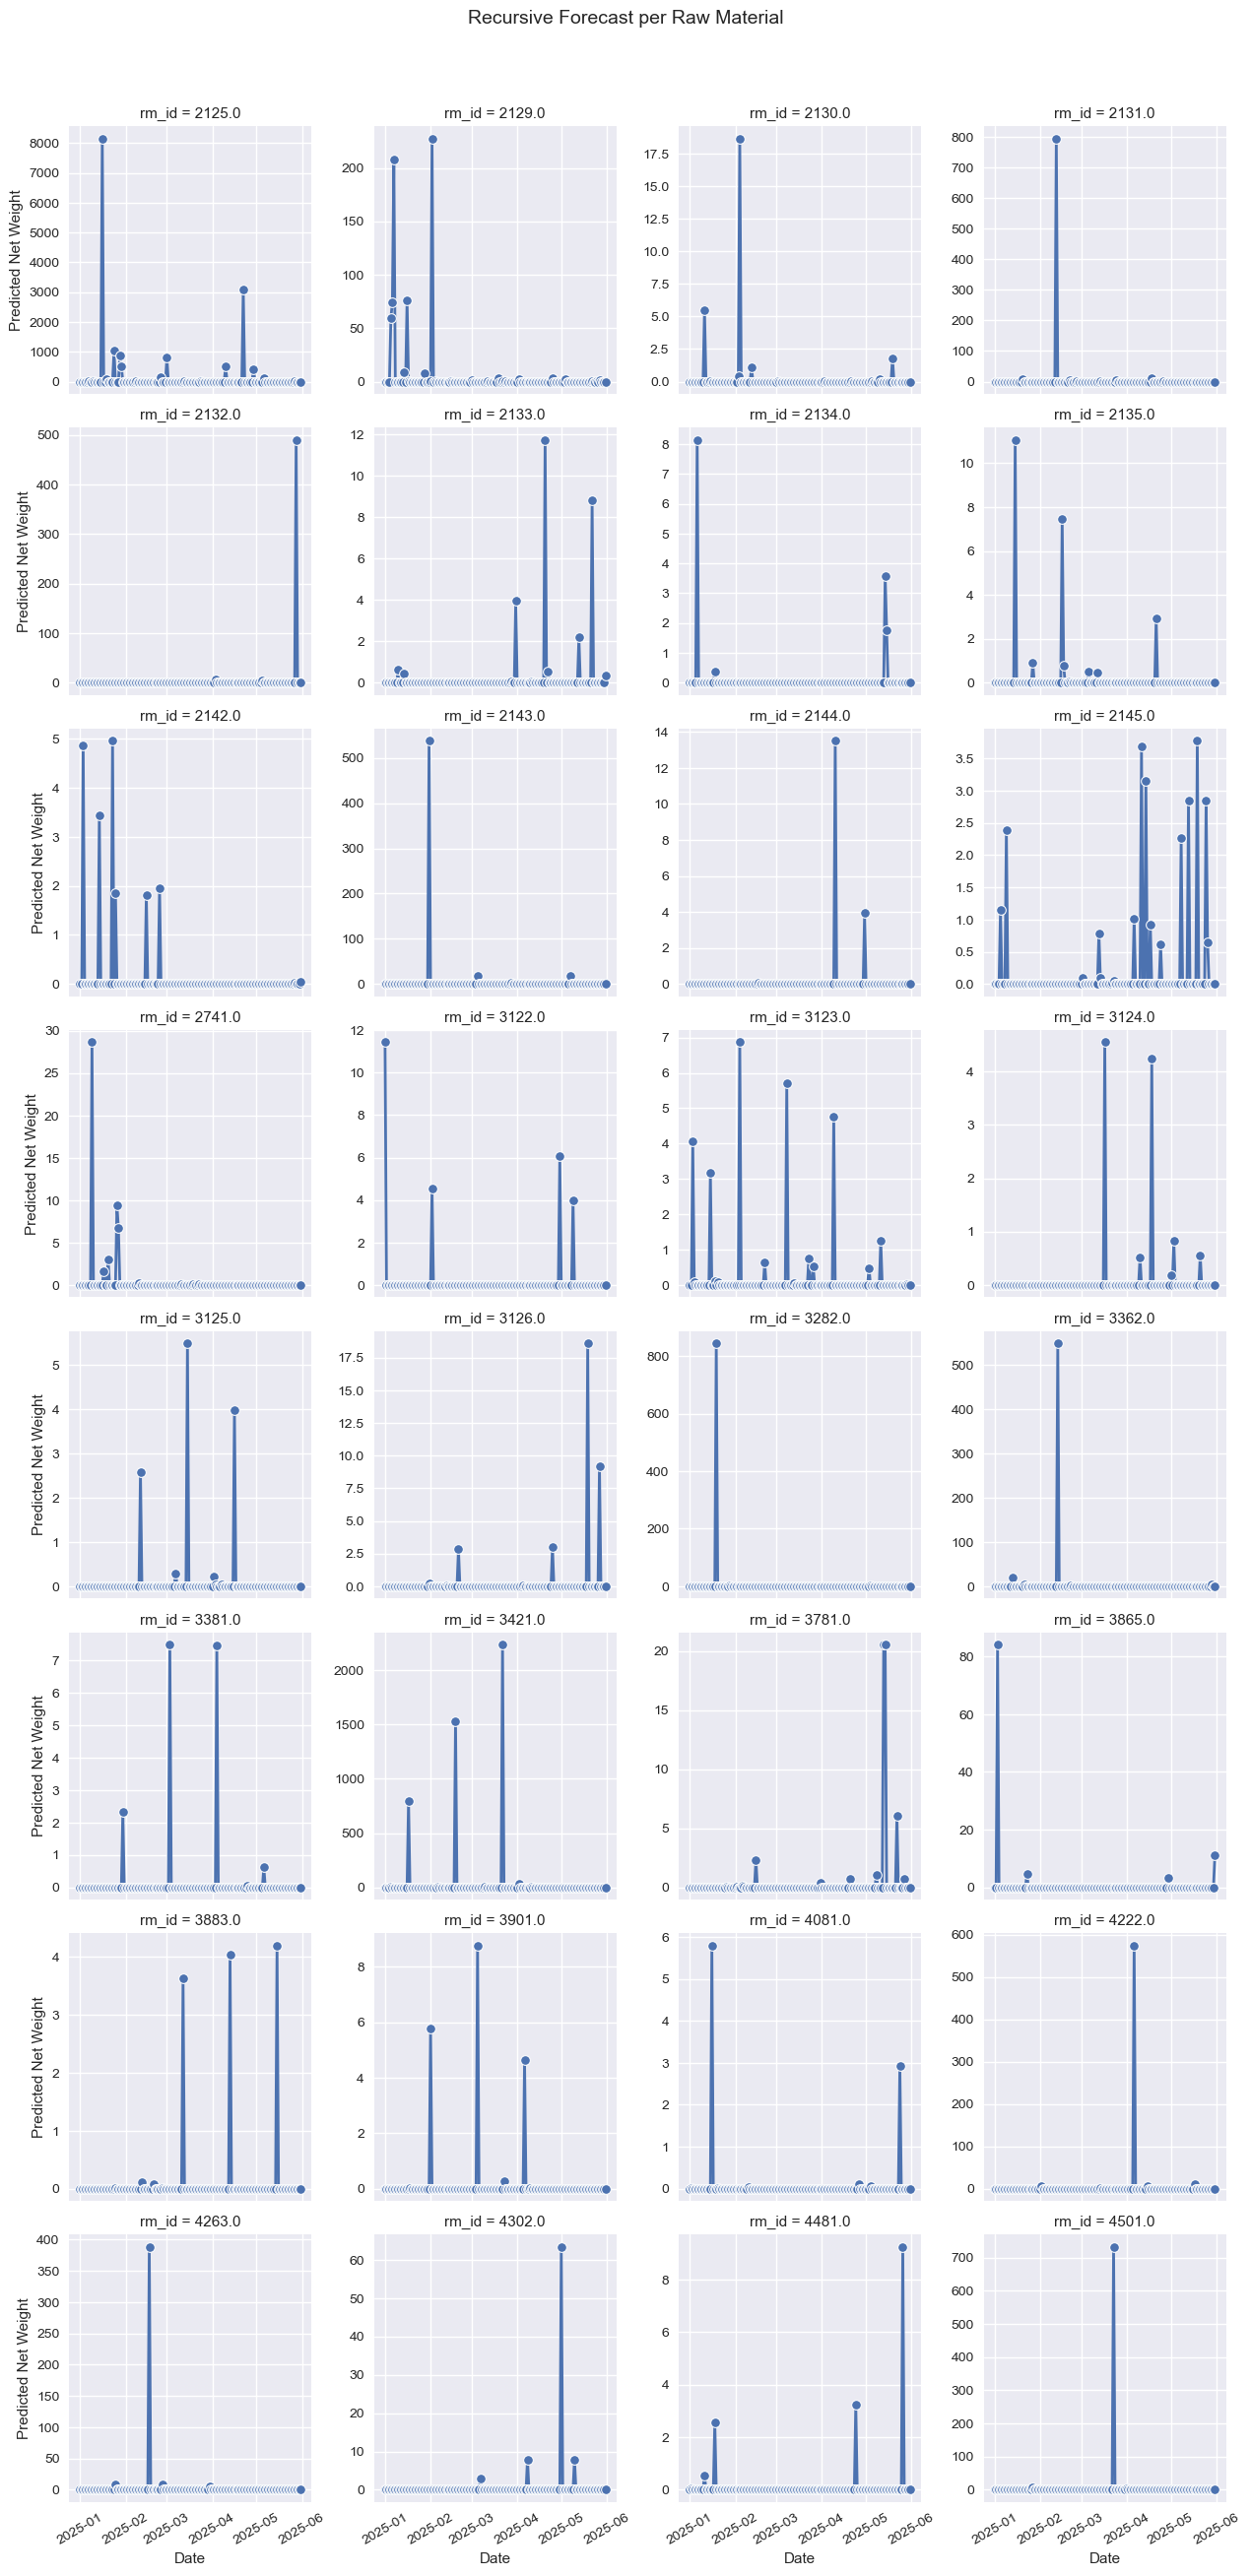

In [61]:
# Ensure correct date type and sorting
submission_frame['date'] = pd.to_datetime(submission_frame['date'])
submission_frame = submission_frame.sort_values(['rm_id', 'date'])

# Create facet grid — one plot per rm_id
g = sns.FacetGrid(
    submission_frame,
    col='rm_id',
    col_wrap=4,          # 4 plots per row → 3 rows for 12 materials
    height=3.2,          # height per subplot
    sharex=True,
    sharey=False,        # each material can have its own y-scale
)

# Add the time series lines
g.map_dataframe(
    sns.lineplot,
    x='date',
    y='y_pred_recursive',
    linewidth=2,
    marker='o'
)

# Titles and labels
g.set_titles("rm_id = {col_name}")
g.set_axis_labels("Date", "Predicted Net Weight")
g.fig.suptitle("Recursive Forecast per Raw Material", fontsize=14, y=1.02)

# Optional: improve date formatting
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(30)

plt.tight_layout()
plt.show()

## Create Kaggle submission

In [62]:
# Ensure correct date type
submission_frame['date'] = pd.to_datetime(submission_frame['date'])

# Filter only 2025 dates (Kaggle forecast period)
submission_2025 = submission_frame[submission_frame['date'] >= '2025-01-01'].copy()

# Sort before cumulative summation
submission_2025.sort_values(['rm_id', 'date'], inplace=True)

# Compute cumulative sums per rm_id
submission_2025['cum_sum'] = (
    submission_2025
    .groupby('rm_id')['y_pred_recursive']
    .cumsum()
)

# Keep only dates from Jan 2 onwards for submission
submission_2025 = submission_2025[submission_2025['date'] >= '2025-01-02'].copy()

# Rename columns for Kaggle format
final_submission = submission_2025.rename(
    columns={
        'date': 'forecast_end_date',
        'cum_sum': 'weight_kg'
    }
)

# Add forecast_start_date (constant for all rows)
final_submission['forecast_start_date'] = pd.Timestamp('2025-01-01')

# Reorder columns to Kaggle’s expected format
final_submission = final_submission[['forecast_start_date', 'forecast_end_date', 'rm_id', 'weight_kg']]

# 5️⃣ Handle missing rm_ids (dead_rms)
forecast_dates = sorted(final_submission['forecast_end_date'].unique())

# Create zero-filled rows for all dead rm_ids across all forecast dates
zero_fill = pd.DataFrame(
    [(pd.Timestamp('2025-01-01'), d, rm, 0.0) for rm in dead_rms for d in forecast_dates],
    columns=['forecast_start_date', 'forecast_end_date', 'rm_id', 'weight_kg']
)

# Combine predicted + zero-filled
final_submission = pd.concat([final_submission, zero_fill], ignore_index=True)

# 6️⃣ Sort and clean
final_submission.sort_values(['rm_id', 'forecast_end_date'], inplace=True)
final_submission.reset_index(drop=True, inplace=True)

# ✅ Preview
print(f"Final submission shape: {final_submission.shape}")
final_submission.head()

Final submission shape: (30450, 4)


,forecast_start_date,forecast_end_date,rm_id,weight_kg
0,2025-01-01,2025-01-02,342.0,0.0
1,2025-01-01,2025-01-03,342.0,0.0
2,2025-01-01,2025-01-04,342.0,0.0
3,2025-01-01,2025-01-05,342.0,0.0
4,2025-01-01,2025-01-06,342.0,0.0


In [63]:
prediction_mapping

,ID,rm_id,forecast_start_date,forecast_end_date
0,1,365,2025-01-01,2025-01-02
1,2,365,2025-01-01,2025-01-03
2,3,365,2025-01-01,2025-01-04
3,4,365,2025-01-01,2025-01-05
4,5,365,2025-01-01,2025-01-06
...,...,...,...,...
30445,30446,4501,2025-01-01,2025-05-27
30446,30447,4501,2025-01-01,2025-05-28
30447,30448,4501,2025-01-01,2025-05-29
30448,30449,4501,2025-01-01,2025-05-30


In [64]:
# Ensure datetime consistency
final_submission['forecast_start_date'] = pd.to_datetime(final_submission['forecast_start_date'])
final_submission['forecast_end_date'] = pd.to_datetime(final_submission['forecast_end_date'])
prediction_mapping['forecast_start_date'] = pd.to_datetime(prediction_mapping['forecast_start_date'])
prediction_mapping['forecast_end_date'] = pd.to_datetime(prediction_mapping['forecast_end_date'])

# Merge predictions with mapping
submission_merged = prediction_mapping.merge(
    final_submission,
    on=['rm_id', 'forecast_start_date', 'forecast_end_date'],
    how='left'
)

# Replace missing predictions (for dead_rms etc.) with 0
submission_merged['weight_kg'] = submission_merged['weight_kg'].fillna(0)

# Rename and select final columns
final_kaggle_submission = (
    submission_merged[['ID', 'weight_kg']]
    .rename(columns={'weight_kg': 'predicted_weight'})
    .sort_values('ID')
    .reset_index(drop=True)
)

# Preview
final_kaggle_submission.head()

,ID,predicted_weight
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0


In [66]:
final_kaggle_submission.to_csv("submission_XGBoost_v0_quantile_loss_refined_inactive_materials.csv", index=False)